In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(714, 3)

In [8]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [9]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.head()

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542
253,30.0,16.1000
719,33.0,7.7750
666,25.0,13.0000


In [12]:
clf = DecisionTreeClassifier()

In [13]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [14]:
accuracy_score(y_test,y_pred)

0.6503496503496503

In [15]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.627445226917058

In [16]:
kbin_age = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')

In [17]:
trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
])

In [18]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [19]:
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ],
      dtype=object)

In [20]:
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ],
      dtype=object)

In [21]:
output = pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})

In [22]:
output['age_labels'] = pd.cut(x=X_train['Age'],
                                    bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'],
                                    bins=trf.named_transformers_['second'].bin_edges_[0].tolist())

In [23]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
869,4.0,0.0,11.1333,5.0,"(0.42, 6.0]","(10.5, 13.0]"
623,21.0,4.0,7.8542,2.0,"(19.0, 21.0]","(7.775, 7.896]"
510,29.0,7.0,7.7500,1.0,"(28.0, 30.0]","(7.25, 7.775]"
597,49.0,13.0,0.0000,0.0,"(47.0, 54.0]",NaN
88,23.0,5.0,263.0000,14.0,"(21.0, 23.0]","(108.9, 512.329]"


In [24]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2 = clf.predict(X_test_trf)

In [25]:
accuracy_score(y_test,y_pred2)

0.6363636363636364

In [26]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.6261150234741784

In [27]:
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)

    trf = ColumnTransformer([
        ('first',kbin_age,[0]),
        ('second',kbin_fare,[1])
    ])

    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))

    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()

    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")

    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


0.6317097026604068


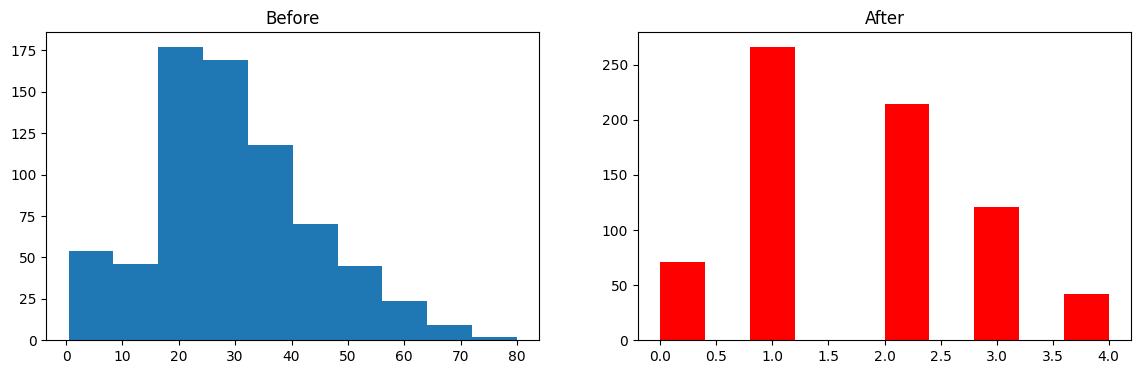

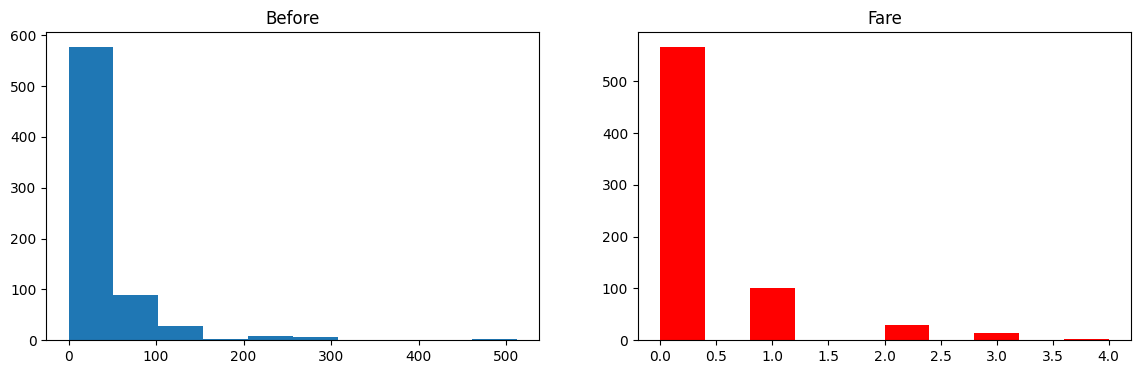

In [30]:
discretize(5,'kmeans')